In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.utils import make_grid
from torchvision import transforms as torch_transforms
from torch.distributions.bernoulli import Bernoulli

In [2]:
import sys
sys.path.append('./../../')

from modules.dvae.model import DVAE
from train_utils.dvae_utils import TemperatureAnnealer
from train_utils.dvae_utils import KLDWeightAnnealer
from train_utils.dvae_utils import KLD_uniform_loss, KLD_codes_uniform_loss

In [3]:
def show(img, figsize=(8, 4)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [4]:
class Config:
    DEVICE                = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    in_channels           = 1
    vocab_size            = 32
    num_x2downsamples     = 2
    num_resids_downsample = 3
    num_resids_bottleneck = 4
    hidden_dim            = 256
    NUM_EPOCHS            = 40
    BATCH_SIZE            = 512
    LR                    = 0.01
    LR_gamma              = 0.1
    step_LR_milestones    = [5, 20, 30]
    temp_start            = 5
    temp_end              = 0.01
    temp_steps            = 100 * 30
    KLD_lambda_start      = 0
    KLD_lambda_end        = 6
    KLD_lambda_steps      = 100 * 20
    
    dvae_path             = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/models/mnist/dvae_vocab32_mnist/"
    dvae_model_name       = "dvae_vocab32_mnist"
    data_path             = "/m/home/home8/82/sukhoba1/data/Desktop/TA-VQVAE/data/MNIST/"

CONFIG = Config()

In [5]:
data_transforms = torch_transforms.Compose([
    torch_transforms.RandomRotation(10),
    torch_transforms.ToTensor()
])

trainset = datasets.MNIST(
    CONFIG.data_path, 
    train=True, 
    transform=data_transforms, 
    download=False)

train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=CONFIG.BATCH_SIZE,
    shuffle=True)

temp_annealer = TemperatureAnnealer(
    start_temp=CONFIG.temp_start,
    end_temp=CONFIG.temp_end,
    n_steps=CONFIG.temp_steps)

kl_annealer = KLDWeightAnnealer(
    start_lambda=CONFIG.KLD_lambda_start,
    end_lambda=CONFIG.KLD_lambda_end,
    n_steps=CONFIG.KLD_lambda_steps)


In [6]:
model = DVAE(in_channels=CONFIG.in_channels,
             vocab_size=CONFIG.vocab_size,
             num_x2downsamples=CONFIG.num_x2downsamples,
             num_resids_downsample=CONFIG.num_resids_downsample,
             num_resids_bottleneck=CONFIG.num_resids_bottleneck,
             hidden_dim=CONFIG.hidden_dim)

model.train()
model.to(CONFIG.DEVICE)

optimizer = optim.Adam(model.parameters(), lr=CONFIG.LR)
lr_scheduler = MultiStepLR(optimizer, milestones=CONFIG.step_LR_milestones, gamma=CONFIG.LR_gamma)


model.show_model_architecture()

DVAE architecture:

Encoder Model:
  ChangeChannels(in=1, out=64)
  DownSampleX2(in=64, out=128)
  ResidualStack(in=128, out=128, n_resid=3)
  DownSampleX2(in=128, out=256)
  ResidualStack(in=256, out=256, n_resid=3)
  ResidualStack(in=256, out=256, n_resid=4)
  DownSampleX2(in=256, out=32)


Decoder Model:
  ChangeChannels(in=32, out=256)
  ResidualStack(in=256, out=256, n_resid=4)
  DownSampleX2(in=256, out=128)
  ResidualStack(in=128, out=128, n_resid=3)
  DownSampleX2(in=128, out=64)
  ResidualStack(in=64, out=64, n_resid=3)
  ChangeChannels(in=64, out=1)




Device in use: cuda
Epoch: 0 Iter: 39 Loss: 0.392708 Recon Loss 0.392582 KL: 0.001258 N codes used: 32
Epoch: 0 Iter: 79 Loss: 0.28077 Recon Loss 0.280527 KL: 0.002425 N codes used: 32
Epoch: 1 Iter: 119 Loss: 0.224795 Recon Loss 0.22449 KL: 0.003042 N codes used: 32
Epoch: 1 Iter: 159 Loss: 0.196169 Recon Loss 0.195807 KL: 0.003625 N codes used: 32
Epoch: 1 Iter: 199 Loss: 0.183664 Recon Loss 0.183296 KL: 0.00368 N codes used: 32
Epoch: 2 Iter: 239 Loss: 0.157541 Recon Loss 0.157164 KL: 0.003766 N codes used: 32
Epoch: 2 Iter: 279 Loss: 0.141295 Recon Loss 0.140865 KL: 0.0043 N codes used: 32
Epoch: 2 Iter: 319 Loss: 0.127951 Recon Loss 0.127542 KL: 0.004096 N codes used: 32
Epoch: 3 Iter: 359 Loss: 0.122497 Recon Loss 0.122029 KL: 0.004675 N codes used: 32
Epoch: 3 Iter: 399 Loss: 0.109941 Recon Loss 0.109531 KL: 0.004101 N codes used: 32
Epoch: 3 Iter: 439 Loss: 0.10493 Recon Loss 0.104505 KL: 0.004257 N codes used: 32
Epoch: 4 Iter: 479 Loss: 0.098841 Recon Loss 0.09841 KL: 0.00431

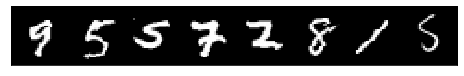

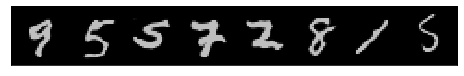

Epoch: 5 Iter: 599 Loss: 0.088704 Recon Loss 0.08819 KL: 0.005139 N codes used: 32
Epoch: 5 Iter: 639 Loss: 0.087292 Recon Loss 0.086753 KL: 0.005399 N codes used: 32
Epoch: 5 Iter: 679 Loss: 0.082683 Recon Loss 0.082112 KL: 0.005714 N codes used: 32
Epoch: 6 Iter: 719 Loss: 0.081743 Recon Loss 0.081159 KL: 0.00584 N codes used: 32
Epoch: 6 Iter: 759 Loss: 0.07906 Recon Loss 0.078441 KL: 0.006188 N codes used: 32
Epoch: 6 Iter: 799 Loss: 0.078721 Recon Loss 0.078053 KL: 0.006679 N codes used: 32
Epoch: 7 Iter: 839 Loss: 0.076846 Recon Loss 0.076166 KL: 0.006798 N codes used: 32
Epoch: 7 Iter: 879 Loss: 0.076994 Recon Loss 0.076224 KL: 0.007703 N codes used: 32
Epoch: 7 Iter: 919 Loss: 0.076119 Recon Loss 0.075362 KL: 0.007566 N codes used: 32
Epoch: 8 Iter: 959 Loss: 0.07362 Recon Loss 0.072768 KL: 0.00852 N codes used: 32
Epoch: 8 Iter: 999 Loss: 0.074824 Recon Loss 0.073957 KL: 0.008672 N codes used: 32
Epoch: 8 Iter: 1039 Loss: 0.072179 Recon Loss 0.071279 KL: 0.008998 N codes used:

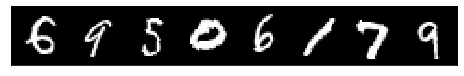

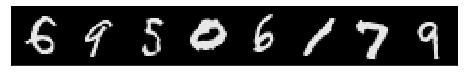

Epoch: 10 Iter: 1199 Loss: 0.070967 Recon Loss 0.069904 KL: 0.01062 N codes used: 32
Epoch: 10 Iter: 1239 Loss: 0.070917 Recon Loss 0.069803 KL: 0.011135 N codes used: 32
Epoch: 10 Iter: 1279 Loss: 0.070294 Recon Loss 0.06913 KL: 0.011637 N codes used: 32
Epoch: 11 Iter: 1319 Loss: 0.072794 Recon Loss 0.071565 KL: 0.012283 N codes used: 32
Epoch: 11 Iter: 1359 Loss: 0.070278 Recon Loss 0.06899 KL: 0.012872 N codes used: 32
Epoch: 11 Iter: 1399 Loss: 0.069602 Recon Loss 0.068291 KL: 0.013109 N codes used: 32
Epoch: 12 Iter: 1439 Loss: 0.070821 Recon Loss 0.0694 KL: 0.01421 N codes used: 32
Epoch: 12 Iter: 1479 Loss: 0.068807 Recon Loss 0.067328 KL: 0.014783 N codes used: 32
Epoch: 12 Iter: 1519 Loss: 0.068714 Recon Loss 0.067225 KL: 0.014888 N codes used: 32
Epoch: 13 Iter: 1559 Loss: 0.070114 Recon Loss 0.068505 KL: 0.016094 N codes used: 32
Epoch: 13 Iter: 1599 Loss: 0.07008 Recon Loss 0.068435 KL: 0.016452 N codes used: 32
Epoch: 13 Iter: 1639 Loss: 0.070146 Recon Loss 0.068373 KL: 0

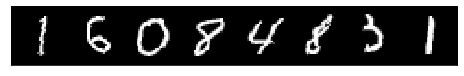

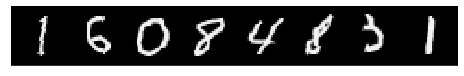

Epoch: 15 Iter: 1799 Loss: 0.070985 Recon Loss 0.068796 KL: 0.021895 N codes used: 32
Epoch: 15 Iter: 1839 Loss: 0.069619 Recon Loss 0.067307 KL: 0.023121 N codes used: 32
Epoch: 15 Iter: 1879 Loss: 0.070247 Recon Loss 0.067719 KL: 0.025281 N codes used: 32
Epoch: 16 Iter: 1919 Loss: 0.070425 Recon Loss 0.067717 KL: 0.027081 N codes used: 32
Epoch: 16 Iter: 1959 Loss: 0.070257 Recon Loss 0.067389 KL: 0.028677 N codes used: 32
Epoch: 16 Iter: 1999 Loss: 0.072724 Recon Loss 0.069598 KL: 0.031263 N codes used: 32
Epoch: 17 Iter: 2039 Loss: 0.071254 Recon Loss 0.067879 KL: 0.033754 N codes used: 32
Epoch: 17 Iter: 2079 Loss: 0.073211 Recon Loss 0.069587 KL: 0.036241 N codes used: 32
Epoch: 17 Iter: 2119 Loss: 0.071046 Recon Loss 0.067106 KL: 0.039401 N codes used: 32
Epoch: 18 Iter: 2159 Loss: 0.071404 Recon Loss 0.067144 KL: 0.042592 N codes used: 32
Epoch: 18 Iter: 2199 Loss: 0.071219 Recon Loss 0.066439 KL: 0.047804 N codes used: 32
Epoch: 18 Iter: 2239 Loss: 0.071573 Recon Loss 0.06648

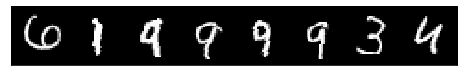

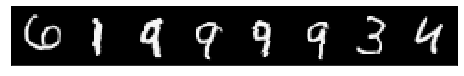

Epoch: 20 Iter: 2399 Loss: 0.075382 Recon Loss 0.067781 KL: 0.076013 N codes used: 32
Epoch: 20 Iter: 2439 Loss: 0.078549 Recon Loss 0.069932 KL: 0.086171 N codes used: 32
Epoch: 21 Iter: 2479 Loss: 0.080371 Recon Loss 0.070714 KL: 0.096567 N codes used: 32
Epoch: 21 Iter: 2519 Loss: 0.080258 Recon Loss 0.069795 KL: 0.104629 N codes used: 32
Epoch: 21 Iter: 2559 Loss: 0.084686 Recon Loss 0.072776 KL: 0.119102 N codes used: 32
Epoch: 22 Iter: 2599 Loss: 0.085318 Recon Loss 0.071848 KL: 0.134699 N codes used: 32
Epoch: 22 Iter: 2639 Loss: 0.087573 Recon Loss 0.0726 KL: 0.149732 N codes used: 32
Epoch: 22 Iter: 2679 Loss: 0.088403 Recon Loss 0.071857 KL: 0.165456 N codes used: 32
Epoch: 23 Iter: 2719 Loss: 0.093725 Recon Loss 0.075141 KL: 0.185843 N codes used: 32
Epoch: 23 Iter: 2759 Loss: 0.095362 Recon Loss 0.074994 KL: 0.203675 N codes used: 32
Epoch: 23 Iter: 2799 Loss: 0.098928 Recon Loss 0.076635 KL: 0.222933 N codes used: 32
Epoch: 24 Iter: 2839 Loss: 0.101206 Recon Loss 0.07707 K

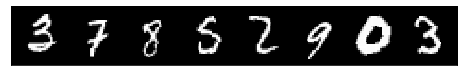

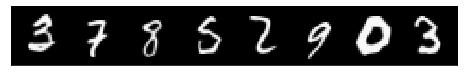

Epoch: 25 Iter: 2959 Loss: 0.110211 Recon Loss 0.08283 KL: 0.273813 N codes used: 32
Epoch: 25 Iter: 2999 Loss: 0.123162 Recon Loss 0.089613 KL: 0.335487 N codes used: 32
Epoch: 25 Iter: 3039 Loss: 0.138511 Recon Loss 0.104478 KL: 0.340333 N codes used: 32
Epoch: 26 Iter: 3079 Loss: 0.128016 Recon Loss 0.095922 KL: 0.320939 N codes used: 32
Epoch: 26 Iter: 3119 Loss: 0.126421 Recon Loss 0.096373 KL: 0.300476 N codes used: 32
Epoch: 26 Iter: 3159 Loss: 0.119924 Recon Loss 0.090852 KL: 0.29072 N codes used: 32
Epoch: 27 Iter: 3199 Loss: 0.117723 Recon Loss 0.089594 KL: 0.281288 N codes used: 32
Epoch: 27 Iter: 3239 Loss: 0.118886 Recon Loss 0.092922 KL: 0.259642 N codes used: 32
Epoch: 27 Iter: 3279 Loss: 0.116766 Recon Loss 0.08981 KL: 0.269564 N codes used: 32
Epoch: 28 Iter: 3319 Loss: 0.11785 Recon Loss 0.090458 KL: 0.273923 N codes used: 32
Epoch: 28 Iter: 3359 Loss: 0.115537 Recon Loss 0.089271 KL: 0.262653 N codes used: 32
Epoch: 28 Iter: 3399 Loss: 0.11486 Recon Loss 0.088741 KL:

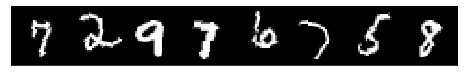

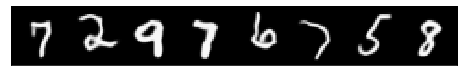

Epoch: 30 Iter: 3559 Loss: 0.112488 Recon Loss 0.087478 KL: 0.250095 N codes used: 32
Epoch: 30 Iter: 3599 Loss: 0.109691 Recon Loss 0.085889 KL: 0.238026 N codes used: 32
Epoch: 30 Iter: 3639 Loss: 0.111857 Recon Loss 0.087461 KL: 0.243964 N codes used: 32
Epoch: 31 Iter: 3679 Loss: 0.11093 Recon Loss 0.086211 KL: 0.247186 N codes used: 32
Epoch: 31 Iter: 3719 Loss: 0.111315 Recon Loss 0.087327 KL: 0.239885 N codes used: 32
Epoch: 31 Iter: 3759 Loss: 0.11092 Recon Loss 0.085785 KL: 0.251349 N codes used: 32
Epoch: 32 Iter: 3799 Loss: 0.110046 Recon Loss 0.085517 KL: 0.245295 N codes used: 32
Epoch: 32 Iter: 3839 Loss: 0.108242 Recon Loss 0.084762 KL: 0.234803 N codes used: 32
Epoch: 32 Iter: 3879 Loss: 0.109773 Recon Loss 0.086832 KL: 0.229409 N codes used: 32
Epoch: 33 Iter: 3919 Loss: 0.110578 Recon Loss 0.086742 KL: 0.238364 N codes used: 32
Epoch: 33 Iter: 3959 Loss: 0.109182 Recon Loss 0.085214 KL: 0.239684 N codes used: 32
Epoch: 33 Iter: 3999 Loss: 0.110624 Recon Loss 0.086794 

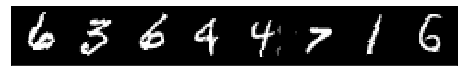

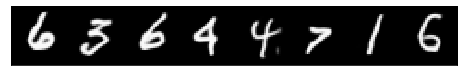

Epoch: 35 Iter: 4159 Loss: 0.106952 Recon Loss 0.084131 KL: 0.228212 N codes used: 32
Epoch: 35 Iter: 4199 Loss: 0.108943 Recon Loss 0.086186 KL: 0.227573 N codes used: 32
Epoch: 35 Iter: 4239 Loss: 0.107554 Recon Loss 0.083569 KL: 0.239852 N codes used: 32
Epoch: 36 Iter: 4279 Loss: 0.110634 Recon Loss 0.085658 KL: 0.249763 N codes used: 32
Epoch: 36 Iter: 4319 Loss: 0.105818 Recon Loss 0.082685 KL: 0.23133 N codes used: 32
Epoch: 36 Iter: 4359 Loss: 0.106624 Recon Loss 0.083264 KL: 0.233604 N codes used: 32
Epoch: 37 Iter: 4399 Loss: 0.105831 Recon Loss 0.082118 KL: 0.237125 N codes used: 32
Epoch: 37 Iter: 4439 Loss: 0.107044 Recon Loss 0.0833 KL: 0.23744 N codes used: 32
Epoch: 37 Iter: 4479 Loss: 0.105025 Recon Loss 0.081283 KL: 0.237416 N codes used: 32
Epoch: 38 Iter: 4519 Loss: 0.107181 Recon Loss 0.084055 KL: 0.231255 N codes used: 32
Epoch: 38 Iter: 4559 Loss: 0.103937 Recon Loss 0.081835 KL: 0.221023 N codes used: 32
Epoch: 38 Iter: 4599 Loss: 0.110429 Recon Loss 0.085789 KL

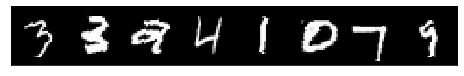

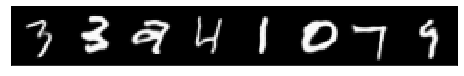

In [7]:
print("Device in use: {}".format(CONFIG.DEVICE))

loss_history = []
recon_loss_history = []
kl_loss_history = []
n_used_codes_history = []
kl_weight_history = []
temp_history = []

iteration = 0
for epoch in range(CONFIG.NUM_EPOCHS):
    for x, _ in train_loader:
        x = x.to(CONFIG.DEVICE)

        optimizer.zero_grad()

        temp = temp_annealer.step(iteration)
        x_recon, z_logits, z = model(x, temp)

        recon_loss = F.binary_cross_entropy(x_recon, x)

        kld_codes_loss = KLD_codes_uniform_loss(z)

        loss = recon_loss + 0.1 * kld_codes_loss

        # dist = Bernoulli(probs=x_recon)
        # recon_loss = - dist.log_prob((x > 0).float()).mean()

        # kld_loss = KLD_uniform_loss(z_logits)
        # kl_weight = kl_annealer.step(iteration)
        
        # loss = recon_loss + kl_weight * kld_loss

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            n_used_codes = len(z.detach().cpu().argmax(dim=1).view(-1).unique())
            if (iteration + 1) % 40 == 0:
                print("Epoch: {} Iter: {} Loss: {} Recon Loss {} KL: {} N codes used: {}".format(
                    epoch, iteration, 
                    round(loss.item(), 6), 
                    round(recon_loss.item(), 6), 
                    round(kld_codes_loss.item(), 6), 
                    round(n_used_codes, 6)
                ))
        
        loss_history.append(loss.item())
        recon_loss_history.append(recon_loss.item())
        # kl_loss_history.append(kld_loss.item())
        # kl_weight_history.append(kl_weight)
        temp_history.append(temp)
        n_used_codes_history.append(n_used_codes)
        
        iteration += 1
    
    if (epoch + 1) % 5 == 0:
        print("====== Epoch {} ======".format(epoch))
        img_grid = make_grid(x[:8, :, :, :].detach().cpu())
        show(img_grid)
        img_recon_grid = make_grid(x_recon[:8, :, :, :].detach().cpu())
        show(img_recon_grid)
        print("======================")


In [8]:
model.save_model(root_path=CONFIG.dvae_path, model_name=CONFIG.dvae_model_name)

# torch.save(model.encoder.state_dict(), "./gdrive/MyDrive/Colab Notebooks/thesis/dvae_M_mnist_encoder.pth")
# torch.save(model.decoder.state_dict(), "./gdrive/MyDrive/Colab Notebooks/thesis/dvae_M_mnist_decoder.pth")

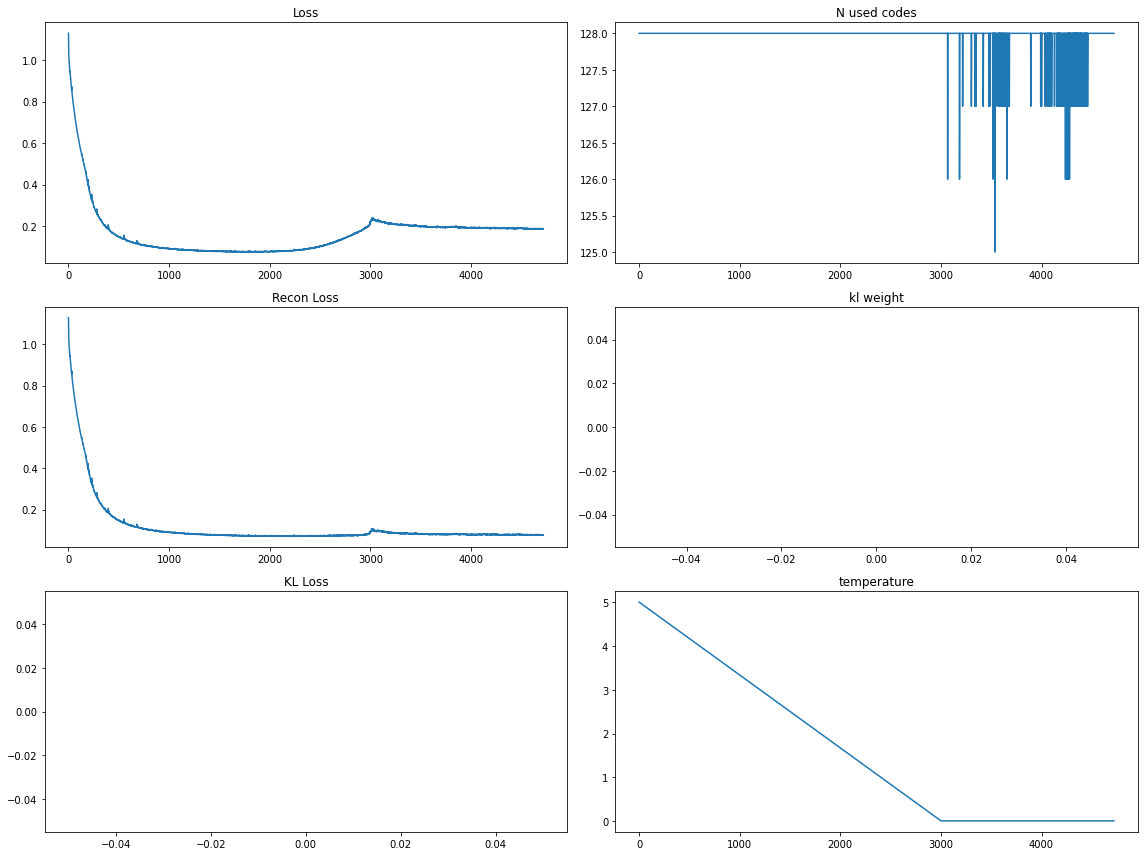

In [12]:
fig = plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(loss_history)
plt.title("Loss")

plt.subplot(3, 2, 3)
plt.plot(recon_loss_history)
plt.title("Recon Loss")

plt.subplot(3, 2, 5)
plt.plot(kl_loss_history)
plt.title("KL Loss")

plt.subplot(3, 2, 2)
plt.plot(n_used_codes_history)
plt.title("N used codes")

plt.subplot(3, 2, 4)
plt.plot(kl_weight_history)
plt.title("kl weight")

plt.subplot(3, 2, 6)
plt.plot(temp_history)
plt.title("temperature")

plt.tight_layout()
plt.show()